In [ ]:
import torch
from ClaD_misogyny import ClaDModel
import jsonlines
from tqdm import tqdm
import numpy as np
from transformers import XLNetTokenizer

NAME='misogyny'

DEV = './simcse-datasets/'+NAME+'/dev.txt'
TEST = './simcse-datasets/'+NAME+'/test.txt'

model = ClaDModel(pretrained_model='xlnet-base-cased', pooling='cls')
state_dict = torch.load('./saved_model_'+NAME+'/simcse_sup_xlnet.pt', map_location=torch.device('cpu'))
state_dict.pop("bert.embeddings.position_ids", None)  
model.load_state_dict(state_dict) 
model.eval()
# Initialize the tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
sentence = "This is an example sentence."    
def convert_to_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512, padding=True)

    with torch.no_grad():
        outputs,_ = model(**inputs)
        outputs_array=outputs.numpy()[0]
        return outputs_array
        
print(convert_to_embedding(sentence))
###train embeddings
src_path='./simcse-datasets/'+NAME+'/train.txt'

def get_positive_embeddings(path,name):
    positive=[]
    with jsonlines.open(path, 'r') as reader:
        for line in tqdm(reader):
            sent1 = line.get(name+'1')
            sent2 = line.get(name+'2')
            positive.append(sent1)
            positive.append(sent2)
    positive=list(set(positive))
    positive_embeddings=[]
    for p in positive:
    
        positive_embeddings.append(convert_to_embedding(p))

    positive_embeddings=np.array(positive_embeddings)
    print(positive_embeddings.shape)
    return positive_embeddings


positive_embeddings=get_positive_embeddings(src_path,NAME)
mean=np.mean(positive_embeddings,axis=0)
std=np.std(positive_embeddings,axis=0)
normalized_data = (positive_embeddings - mean) / std
covariance_matrix = np.cov(normalized_data, rowvar=False)




[ 2.76370382e+00 -5.00820494e+00 -8.43942046e-01  1.75081909e+00
 -5.55749536e-01  1.81605732e+00  6.67497754e-01  1.79255629e+00
 -3.45933497e-01 -2.65342855e+00  2.44270492e+00 -2.16285729e+00
 -3.48748040e+00 -1.24360979e+00  1.00930095e-01  1.62559628e+00
  1.22399652e+00 -2.48711038e+00  2.07645869e+00  1.32979822e+00
  9.68767405e-01  3.50737381e+00  1.55418134e+00  2.95023382e-01
 -7.53479958e-01  3.41294241e+00  3.65103900e-01  1.66485858e+00
 -4.38441873e-01  3.36989522e+00  1.10029888e+00  8.18856716e-01
  1.89074886e+00  7.71075189e-01 -1.49221945e+00 -3.29566672e-02
  2.21815896e+00  5.14280975e-01 -3.57184124e+00  2.58256793e-01
  5.84523964e+00  2.14657760e+00  3.55780625e+00  4.15106416e-02
 -1.85309660e+00 -1.53020763e+00 -9.92958546e-01  3.07971692e+00
  2.08604559e-01  6.05200052e-01  2.53264284e+00 -2.74967909e+00
  1.34119129e+00  1.88969088e+00 -8.57547283e-01  3.42705965e-01
  1.56372225e+00  4.14628655e-01 -1.58297610e+00 -2.48367667e+00
  1.30869365e+00  1.68577

10631it [00:00, 372272.19it/s]


(1634, 768)


In [ ]:
import jsonlines
from tqdm import tqdm


test_path='./simcse-datasets/'+NAME+'/dev.txt'
names=['source','content','label']
def load_test_data(path,names):
    pred_test=[]
    real=[]
    origin=[]
    comment=[]
    with jsonlines.open(path, 'r') as reader:
        for line in tqdm(reader):
            sent1 = line.get(names[0])
            sent2 = line.get(names[1])
            label = line.get(names[2])
            if sent2 not in comment:
                real.append(label)
                origin.append(sent1)
                comment.append(sent2)
    return comment,real
comment,real = load_test_data(test_path,names)
len(comment)

656it [00:00, 146979.88it/s]

['And White people who bring up queerness or being a survivor as a way to SILENCE WoC? Because no WoC are queer? None survivors too? Ugh.', 'Parents usually maintain stricter control over their daughters than their sons, and they should', 'It is important for a man to be strong', "MENTION3100 MENTION3832 I'd never punch a girl!", 'I’m not a fan of this person commentating on the football!', "ANOTHER home visits round?! i'm literally fucking done #MKR", 'Women should have the same sexual freedom as men', "I think you've been estimated enough #mkr", "I don't find potty humor funny, even less so when done by women.", 'You can eliminate teams by strategically voting, but what sort of person does that make you? A chef, or a petty person? #MKR', 'Im with MENTION1637 booooo\n#mkr', 'Another instant restaraunt round!? Happy and sad bout this #MKR', 'Haha sucked in Kat & Andre #cantcook #boringfood #MKR', "MENTION461 MENTION2784 please untag me from all of this. it's spamming my notifications."

655

In [ ]:
import scipy.stats as stats
import numpy as np

def cal_mah(new_data, data_points):
    n = data_points.shape[0]
    d = data_points.shape[1]
    data = np.vstack((new_data, data_points))
    mean = np.mean(data, axis=0)
    covariance_matrix = np.cov(data, rowvar=False)

    difference_vector = (new_data - mean)
    inverse_covariance_matrix = np.linalg.pinv(covariance_matrix)
    squared_distance = np.dot(np.dot(difference_vector.T, inverse_covariance_matrix), difference_vector)
    return squared_distance

def ag1(squared_distance, data_points,alpha):
    n = data_points.shape[0]
    d = data_points.shape[1]
    print(n,d)
    T = (n+1)/(n**2) * squared_distance

    p = d/2  # Shape parameter alpha of Beta distribution
    q = (n-d)/2  # Shape parameter beta of Beta distribution
    # Significance level alpha
    # Compute critical value for the upper tail (e.g., 95th percentile)
    critical_value_upper = stats.beta.ppf(1 - alpha, p, q)
    # print(critical_value_upper)
    # print(T)
    # print('===========')

    if T > critical_value_upper:
        return 0  # Abnormal (above the critical value)
    else:
        return 1  # Normal




In [ ]:
Squared_distance=[]
data = positive_embeddings
for i in range(len(comment)):
    arr=convert_to_embedding(comment[i])
    
    s=cal_mah(arr,data)
    Squared_distance.append(s)
    

0
100
200
300
400
500
600


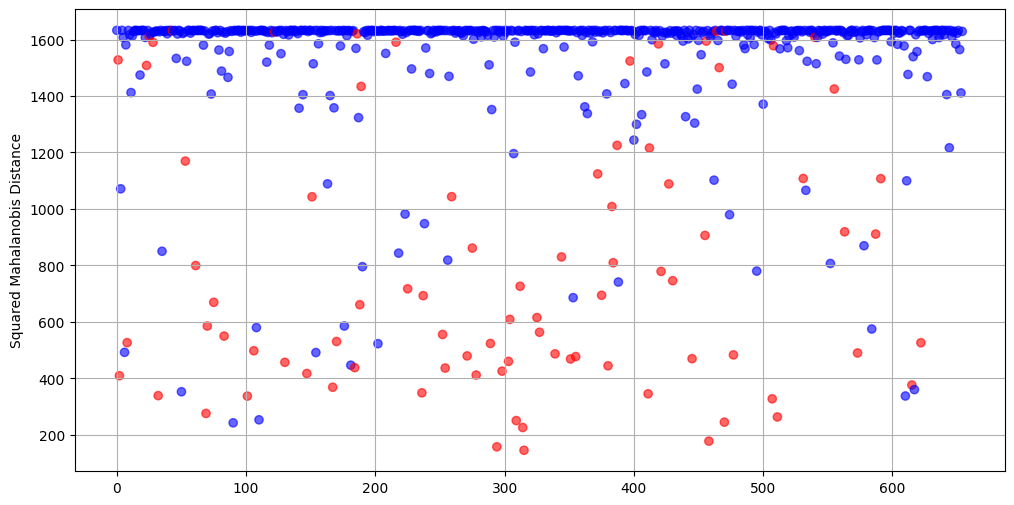

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


categories = np.array(real)
lengths = np.array(Squared_distance)
plt.figure(figsize=(12, 6))
colors = ['blue' if x == 0 else 'red' for x in categories]  
plt.scatter(range(len(lengths)), lengths, c=colors, alpha=0.6)  

plt.title('')
plt.xlabel('')
plt.ylabel('Squared Mahalanobis Distance')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

alpha=[1e-16]
results=[]
for a in alpha:
    pred_using_ag1=[]
    for i in range(len(Squared_distance)):
        
        s=Squared_distance[i]
        
        result=ag1(s,data,a)
        
        pred_using_ag1.append(result)
    y_true=real
    y_pred=pred_using_ag1
    # 
    accuracy = accuracy_score(y_true, y_pred)

    # 
    precision = precision_score(y_true, y_pred)

    # 
    recall = recall_score(y_true, y_pred)

    # 
    f1 = f1_score(y_true, y_pred)
    results.append([accuracy,precision,recall,f1])

    
    

0
1634 768
0.6120873894895799
0.9997753508178367
1634 768
0.6120873894895799
0.9356000434930505
1634 768
0.6120873894895799
0.25063569424498283
1634 768
0.6120873894895799
0.656021810575708
1634 768
0.6120873894895799
0.999735147786923
1634 768
0.6120873894895799
0.9844606392602187
1634 768
0.6120873894895799
0.30134053074979494
1634 768
0.6120873894895799
0.9682941621452017
1634 768
0.6120873894895799
0.32235191833307
1634 768
0.6120873894895799
0.9996411085572497
1634 768
0.6120873894895799
0.9899947029188527
1634 768
0.6120873894895799
0.8648149007299842
1634 768
0.6120873894895799
0.9876134489102386
1634 768
0.6120873894895799
0.9973173978741776
1634 768
0.6120873894895799
0.9997459468111466
1634 768
0.6120873894895799
0.9995236650206133
1634 768
0.6120873894895799
0.9989333550154724
1634 768
0.6120873894895799
0.9991601121160294
1634 768
0.6120873894895799
0.9028908604785132
1634 768
0.6120873894895799
0.9996376429319886
1634 768
0.6120873894895799
0.9997504021972113
1634 768
0.61

In [129]:
print(results)

[[0.9206106870229007, 0.7037037037037037, 0.6705882352941176, 0.6867469879518073]]


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

fpr = fp / (fp + tn)

print(f'False Positive Rate: {fpr}')


False Positive Rate: 0.042105263157894736
